In [58]:
# https://www.kaggle.com/code/robikscube/time-series-forecasting-with-machine-learning-yt

In [59]:
# https://www.kaggle.com/competitions/godaddy-microbusiness-density-forecasting/discussion/372780

In [60]:
# https://towardsdatascience.com/interpreting-acf-and-pacf-plots-for-time-series-forecasting-af0d6db4061c
# https://www.analyticsvidhya.com/blog/2019/12/6-powerful-feature-engineering-techniques-time-series/

In [61]:
import warnings
warnings.simplefilter("ignore")

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [63]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

# 1. Load data

In [64]:
df = pd.read_csv('PJME_hourly.csv')

In [65]:
df.sample(5)

,Datetime,PJME_MW
138855,2017-02-27 17:00:00,31089.0
135359,2017-07-24 00:00:00,33158.0
90941,2012-08-15 04:00:00,27864.0
14588,2003-05-04 00:00:00,23344.0
116772,2015-09-04 13:00:00,46432.0


In [66]:
df.shape

(145366, 2)

# 2. Check data quality

data type

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145366 entries, 0 to 145365
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  145366 non-null  object 
 1   PJME_MW   145366 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.2+ MB


In [68]:
df['Datetime'] = pd.to_datetime(df['Datetime'])

In [69]:
df.sort_values('Datetime', inplace=True)

unique value

In [70]:
df.shape

(145366, 2)

In [71]:
for i in df.columns:
    print('Columns name: ', i)
    print('Unique value: ', df[i].unique())
    print('Count unique value: ', df[i].nunique())
    print('-'*10)

Columns name:  Datetime
Unique value:  <DatetimeArray>
['2002-01-01 01:00:00', '2002-01-01 02:00:00', '2002-01-01 03:00:00',
 '2002-01-01 04:00:00', '2002-01-01 05:00:00', '2002-01-01 06:00:00',
 '2002-01-01 07:00:00', '2002-01-01 08:00:00', '2002-01-01 09:00:00',
 '2002-01-01 10:00:00',
 ...
 '2018-08-02 15:00:00', '2018-08-02 16:00:00', '2018-08-02 17:00:00',
 '2018-08-02 18:00:00', '2018-08-02 19:00:00', '2018-08-02 20:00:00',
 '2018-08-02 21:00:00', '2018-08-02 22:00:00', '2018-08-02 23:00:00',
 '2018-08-03 00:00:00']
Length: 145362, dtype: datetime64[ns]
Count unique value:  145362
----------
Columns name:  PJME_MW
Unique value:  [30393. 29265. 28357. ... 44094. 40666. 46816.]
Count unique value:  28441
----------


In [72]:
df[df.duplicated('Datetime', keep=False)]

,Datetime,PJME_MW
106585,2014-11-02 02:00:00,23755.0
106584,2014-11-02 02:00:00,22935.0
115368,2015-11-01 02:00:00,21567.0
115369,2015-11-01 02:00:00,21171.0
124008,2016-11-06 02:00:00,20795.0
124009,2016-11-06 02:00:00,21692.0
132816,2017-11-05 02:00:00,21236.0
132817,2017-11-05 02:00:00,20666.0


In [73]:
df = df.groupby('Datetime')['PJME_MW'].mean().reset_index()

In [74]:
df.rename(columns={'PJME_MW': 'PJME_MW'}, inplace=True)

In [75]:
df.shape

(145362, 2)

missing value

In [76]:
df.isnull().sum()

Datetime    0
PJME_MW     0
dtype: int64

zero value

In [77]:
(df == 0).sum()

Datetime    0
PJME_MW     0
dtype: int64

blank value

In [78]:
(df == '').sum()

Datetime    0
PJME_MW     0
dtype: int64

# 3. Exploratory data analysis (EDA)

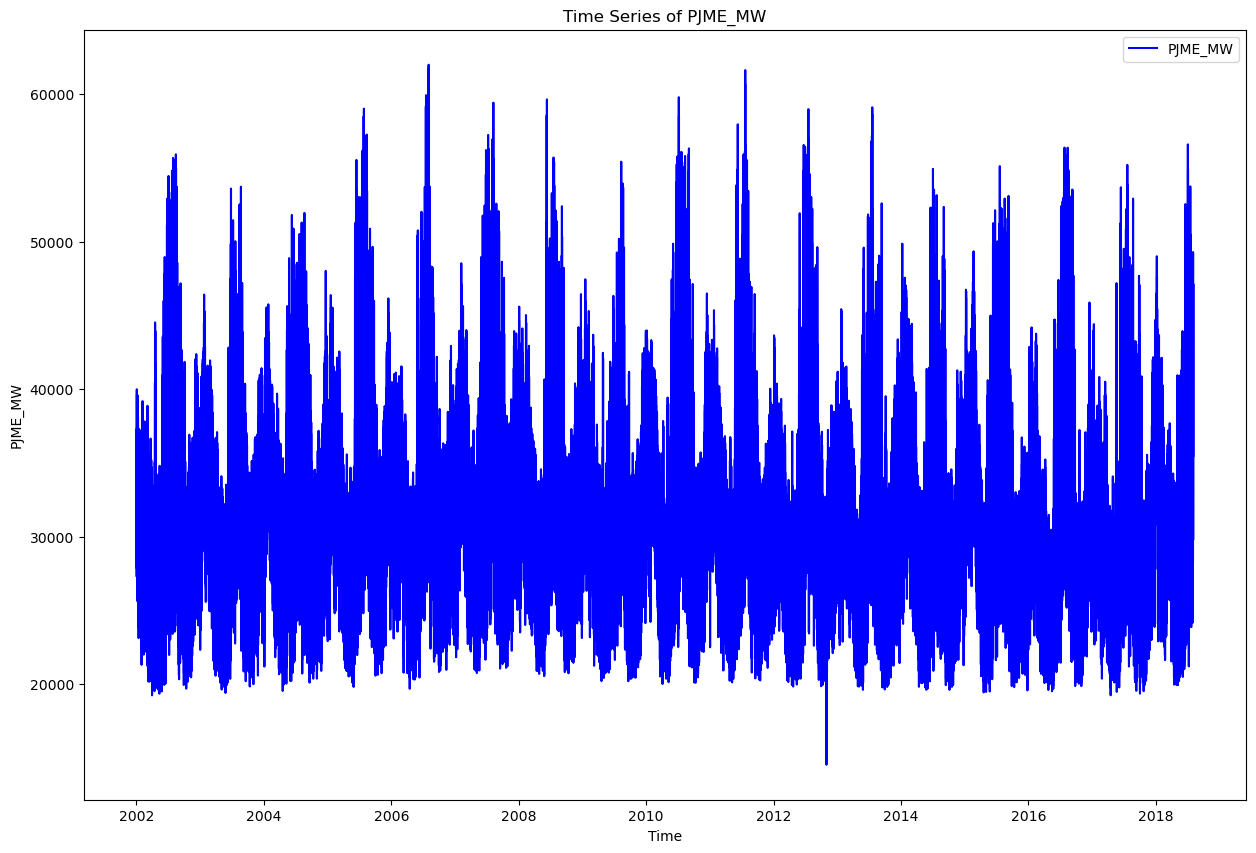

In [79]:
plt.figure(figsize=(15, 10))
plt.plot(df['Datetime'], df['PJME_MW'], label='PJME_MW', color='blue')
plt.xlabel('Time')
plt.ylabel('PJME_MW')
plt.legend()
plt.title('Time Series of PJME_MW')
plt.show()

<Figure size 2000x1000 with 0 Axes>

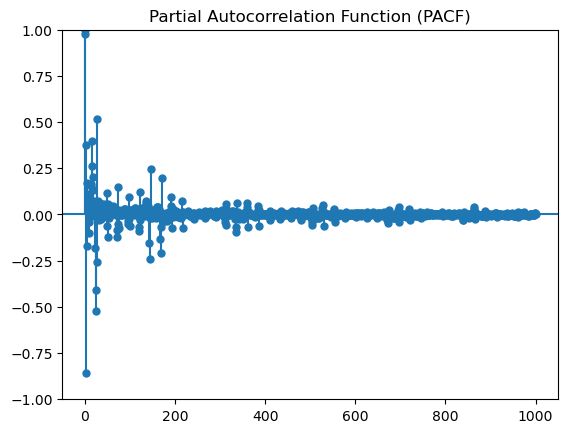

In [80]:
plt.figure(figsize=(20, 10))
plot_pacf(df['PJME_MW'], lags=1000)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

<Figure size 2000x700 with 0 Axes>

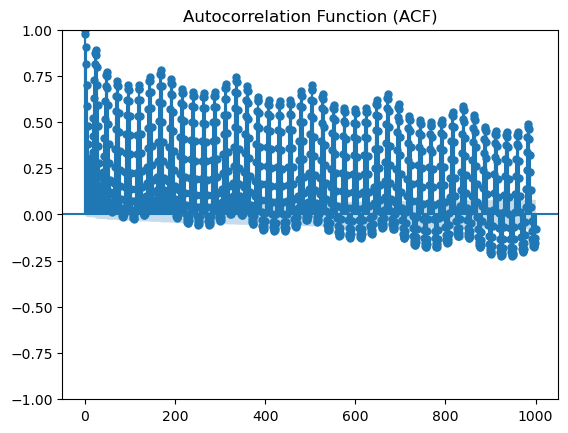

In [81]:
plt.figure(figsize=(20, 7))
plot_acf(df['PJME_MW'], lags=1000)
plt.title('Autocorrelation Function (ACF)')
plt.show()

<Figure size 2000x700 with 0 Axes>

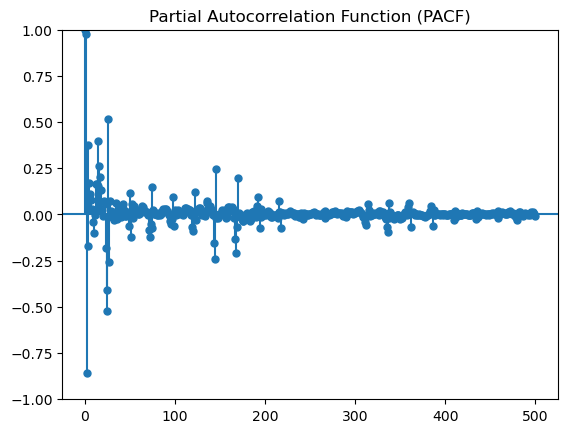

In [82]:
plt.figure(figsize=(20, 7))
plot_pacf(df['PJME_MW'], lags=500)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

<Figure size 2000x700 with 0 Axes>

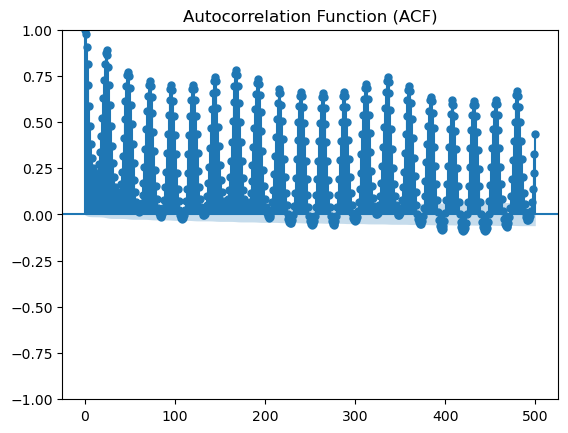

In [83]:
plt.figure(figsize=(20, 7))
plot_acf(df['PJME_MW'], lags=500)
plt.title('Autocorrelation Function (ACF)')
plt.show()

<Figure size 2000x700 with 0 Axes>

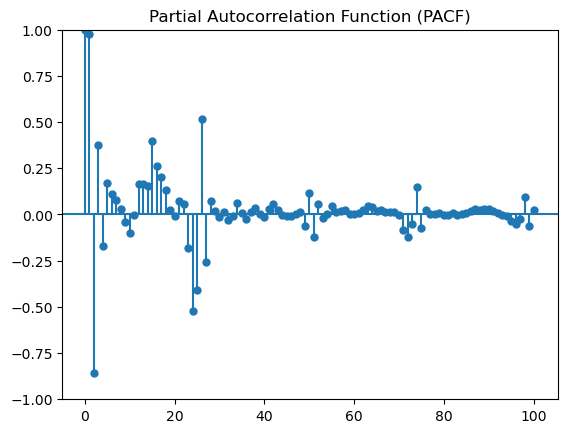

In [84]:
plt.figure(figsize=(20, 7))
plot_pacf(df['PJME_MW'], lags=100)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

<Figure size 2000x700 with 0 Axes>

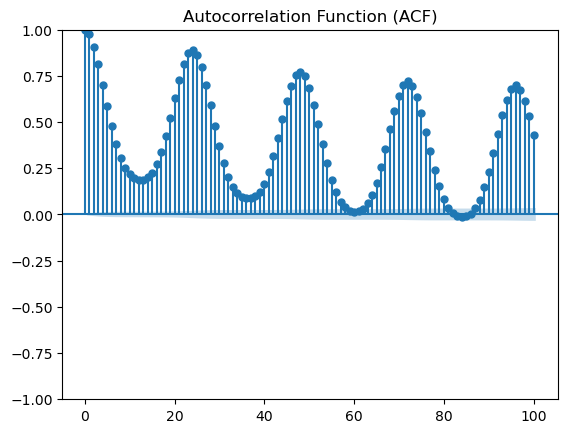

In [85]:
plt.figure(figsize=(20, 7))
plot_acf(df['PJME_MW'], lags=100)
plt.title('Autocorrelation Function (ACF)')
plt.show()

<Figure size 2000x700 with 0 Axes>

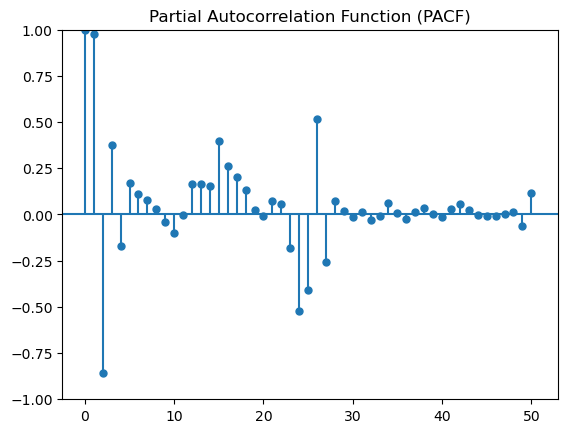

In [86]:
plt.figure(figsize=(20, 7))
plot_pacf(df['PJME_MW'], lags=50)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

<Figure size 2000x700 with 0 Axes>

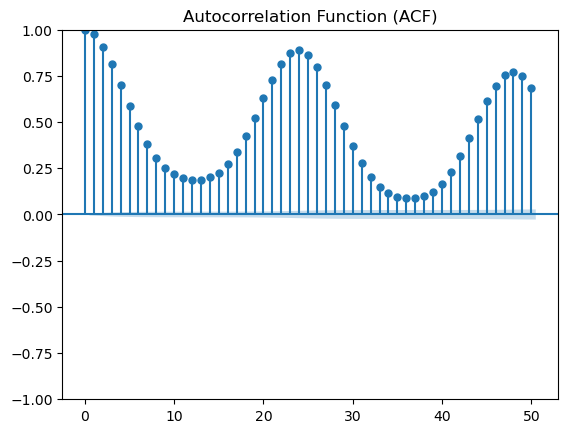

In [87]:
plt.figure(figsize=(20, 7))
plot_acf(df['PJME_MW'], lags=50)
plt.title('Autocorrelation Function (ACF)')
plt.show()

In [88]:
# lag_hours = [1, 2, 3, 6, 12, 24, 48, 72, 96, 120, 144, 168]

# 3. Feature engineering

Datetime features

In [89]:
df['hour'] = df['Datetime'].dt.hour
df['sin_hour'] = np.sin(2 * np.pi * df['Datetime'].dt.hour / 24)
df['cos_hour'] = np.cos(2 * np.pi * df['Datetime'].dt.hour / 24)

In [90]:
df['dayofweek'] = df['Datetime'].dt.dayofweek
df['sin_dayofweek'] = np.sin(2 * np.pi * df['Datetime'].dt.dayofweek / 7)
df['cos_dayofweek'] = np.cos(2 * np.pi * df['Datetime'].dt.dayofweek / 7)

In [91]:
df['quarter'] = df['Datetime'].dt.quarter
df['sin_quarter'] = np.sin(2 * np.pi * df['Datetime'].dt.quarter / 4)
df['cos_quarter'] = np.cos(2 * np.pi * df['Datetime'].dt.quarter / 4)

In [92]:
df['month'] = df['Datetime'].dt.month
df['sin_month'] = np.sin(2 * np.pi * df['Datetime'].dt.month / 12)
df['cos_month'] = np.cos(2 * np.pi * df['Datetime'].dt.month / 12)

In [93]:
min_year = df['Datetime'].dt.year.min()
num_unique_years = df['Datetime'].dt.year.nunique()
df['year'] = (df['Datetime'].dt.year)-min_year
df['sin_year'] = np.sin(2 * np.pi * df['year'] / num_unique_years)
df['cos_year'] = np.cos(2 * np.pi * df['year'] / num_unique_years)

In [94]:
df['dayofyear'] = df['Datetime'].dt.dayofyear
df['dayofmonth'] = df['Datetime'].dt.day
df['weekofyear'] = df['Datetime'].dt.isocalendar().week
df['weekofmonth'] = np.ceil(df['dayofmonth'] / 7).astype(int)
df['is_weekend'] = (df['Datetime'].dt.dayofweek >= 5).astype(int)
df['is_leap_year'] = df['Datetime'].dt.is_leap_year.astype(int)
df['is_month_start'] = df['Datetime'].dt.is_month_start.astype(int)
df['is_month_end'] = df['Datetime'].dt.is_month_end.astype(int)
df['is_year_start'] = df['Datetime'].dt.is_year_start.astype(int)
df['is_year_end'] = df['Datetime'].dt.is_year_end.astype(int)

In [95]:
df.head()

,Datetime,PJME_MW,hour,sin_hour,cos_hour,dayofweek,sin_dayofweek,cos_dayofweek,quarter,sin_quarter,...,dayofyear,dayofmonth,weekofyear,weekofmonth,is_weekend,is_leap_year,is_month_start,is_month_end,is_year_start,is_year_end
0,2002-01-01 01:00:00,30393.0,1,0.258819,0.965926,1,0.781831,0.62349,1,1.0,...,1,1,1,1,0,0,1,0,1,0
1,2002-01-01 02:00:00,29265.0,2,0.500000,0.866025,1,0.781831,0.62349,1,1.0,...,1,1,1,1,0,0,1,0,1,0
2,2002-01-01 03:00:00,28357.0,3,0.707107,0.707107,1,0.781831,0.62349,1,1.0,...,1,1,1,1,0,0,1,0,1,0
3,2002-01-01 04:00:00,27899.0,4,0.866025,0.500000,1,0.781831,0.62349,1,1.0,...,1,1,1,1,0,0,1,0,1,0
4,2002-01-01 05:00:00,28057.0,5,0.965926,0.258819,1,0.781831,0.62349,1,1.0,...,1,1,1,1,0,0,1,0,1,0


Lag features

In [96]:
lag_hours = [1, 2, 3, 6, 12, 24, 48, 72, 96, 120, 144, 168]

In [97]:
for lag in lag_hours:
    df[f'PJME_MW_lag_{lag}h'] = df['PJME_MW'].shift(periods=lag)
df.fillna(method='bfill', inplace=True)

In [98]:
df.reset_index(inplace=True)

In [99]:
df.head()

,index,Datetime,PJME_MW,hour,sin_hour,cos_hour,dayofweek,sin_dayofweek,cos_dayofweek,quarter,...,PJME_MW_lag_3h,PJME_MW_lag_6h,PJME_MW_lag_12h,PJME_MW_lag_24h,PJME_MW_lag_48h,PJME_MW_lag_72h,PJME_MW_lag_96h,PJME_MW_lag_120h,PJME_MW_lag_144h,PJME_MW_lag_168h
0,0,2002-01-01 01:00:00,30393.0,1,0.258819,0.965926,1,0.781831,0.62349,1,...,30393.0,30393.0,30393.0,30393.0,30393.0,30393.0,30393.0,30393.0,30393.0,30393.0
1,1,2002-01-01 02:00:00,29265.0,2,0.500000,0.866025,1,0.781831,0.62349,1,...,30393.0,30393.0,30393.0,30393.0,30393.0,30393.0,30393.0,30393.0,30393.0,30393.0
2,2,2002-01-01 03:00:00,28357.0,3,0.707107,0.707107,1,0.781831,0.62349,1,...,30393.0,30393.0,30393.0,30393.0,30393.0,30393.0,30393.0,30393.0,30393.0,30393.0
3,3,2002-01-01 04:00:00,27899.0,4,0.866025,0.500000,1,0.781831,0.62349,1,...,30393.0,30393.0,30393.0,30393.0,30393.0,30393.0,30393.0,30393.0,30393.0,30393.0
4,4,2002-01-01 05:00:00,28057.0,5,0.965926,0.258819,1,0.781831,0.62349,1,...,29265.0,30393.0,30393.0,30393.0,30393.0,30393.0,30393.0,30393.0,30393.0,30393.0


MA

In [100]:
ma_periods = [1, 2, 3, 6, 12, 24, 48, 72, 96, 120, 144, 168]

In [101]:
for ma_period in ma_periods:
    df[f'PJME_MW_MA_{ma_period}h'] = df['PJME_MW'].rolling(window=ma_period).mean()
df.fillna(method='bfill', inplace=True)

In [102]:
df.reset_index(inplace=True)

In [103]:
df.head()

,level_0,index,Datetime,PJME_MW,hour,sin_hour,cos_hour,dayofweek,sin_dayofweek,cos_dayofweek,...,PJME_MW_MA_3h,PJME_MW_MA_6h,PJME_MW_MA_12h,PJME_MW_MA_24h,PJME_MW_MA_48h,PJME_MW_MA_72h,PJME_MW_MA_96h,PJME_MW_MA_120h,PJME_MW_MA_144h,PJME_MW_MA_168h
0,0,0,2002-01-01 01:00:00,30393.0,1,0.258819,0.965926,1,0.781831,0.62349,...,29338.333333,28770.833333,29587.833333,31017.5,32678.854167,33284.125,33390.770833,32777.7,32364.0,32519.511905
1,1,1,2002-01-01 02:00:00,29265.0,2,0.500000,0.866025,1,0.781831,0.62349,...,29338.333333,28770.833333,29587.833333,31017.5,32678.854167,33284.125,33390.770833,32777.7,32364.0,32519.511905
2,2,2,2002-01-01 03:00:00,28357.0,3,0.707107,0.707107,1,0.781831,0.62349,...,29338.333333,28770.833333,29587.833333,31017.5,32678.854167,33284.125,33390.770833,32777.7,32364.0,32519.511905
3,3,3,2002-01-01 04:00:00,27899.0,4,0.866025,0.500000,1,0.781831,0.62349,...,28507.000000,28770.833333,29587.833333,31017.5,32678.854167,33284.125,33390.770833,32777.7,32364.0,32519.511905
4,4,4,2002-01-01 05:00:00,28057.0,5,0.965926,0.258819,1,0.781831,0.62349,...,28104.333333,28770.833333,29587.833333,31017.5,32678.854167,33284.125,33390.770833,32777.7,32364.0,32519.511905


Correlation

In [104]:
corr = df.corr()

<Axes: >

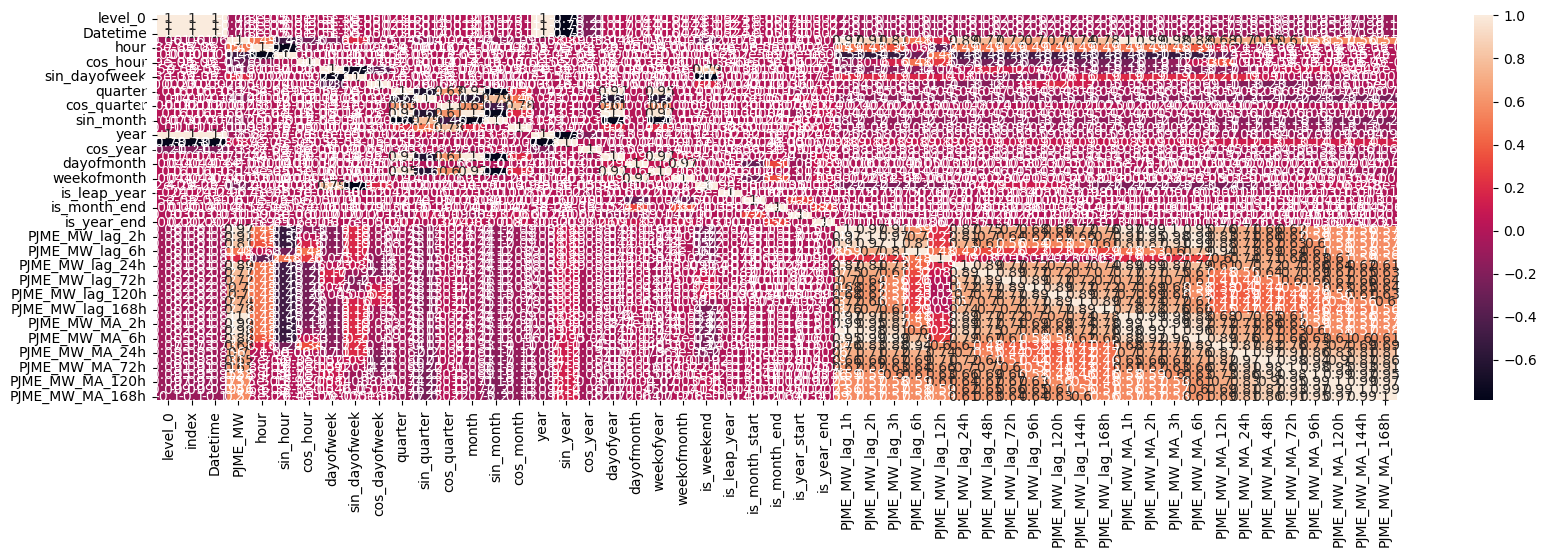

In [105]:
fig, ax = plt.subplots(figsize=(20, 5))
sns.heatmap(corr, annot=True, ax=ax)

In [106]:
corr_churn_table = corr['PJME_MW'].sort_values(ascending=False)

In [107]:
corr_churn_table

PJME_MW_MA_1h       1.000000
PJME_MW             1.000000
PJME_MW_MA_2h       0.993671
PJME_MW_MA_3h       0.976393
PJME_MW_lag_1h      0.974764
PJME_MW_lag_2h      0.907509
PJME_MW_lag_24h     0.891375
PJME_MW_MA_6h       0.882768
PJME_MW_lag_3h      0.812477
PJME_MW_lag_168h    0.781664
PJME_MW_lag_48h     0.772608
PJME_MW_lag_144h    0.744196
PJME_MW_lag_72h     0.720443
PJME_MW_MA_24h      0.702532
PJME_MW_lag_120h    0.699496
PJME_MW_lag_96h     0.698927
PJME_MW_MA_12h      0.680132
PJME_MW_MA_48h      0.651184
PJME_MW_MA_72h      0.609801
PJME_MW_MA_96h      0.582855
PJME_MW_MA_168h     0.566397
PJME_MW_MA_120h     0.566338
PJME_MW_MA_144h     0.561477
hour                0.486272
PJME_MW_lag_6h      0.476419
sin_dayofweek       0.194052
PJME_MW_lag_12h     0.188512
sin_year            0.089400
cos_quarter         0.002302
dayofmonth          0.000016
weekofmonth        -0.000327
is_year_end        -0.001542
is_month_end       -0.001713
is_leap_year       -0.007489
is_month_start

In [108]:
corr_churn_abs_table = corr['PJME_MW'].abs().sort_values(ascending=False)

In [109]:
corr_churn_abs_table

PJME_MW             1.000000
PJME_MW_MA_1h       1.000000
PJME_MW_MA_2h       0.993671
PJME_MW_MA_3h       0.976393
PJME_MW_lag_1h      0.974764
PJME_MW_lag_2h      0.907509
PJME_MW_lag_24h     0.891375
PJME_MW_MA_6h       0.882768
PJME_MW_lag_3h      0.812477
PJME_MW_lag_168h    0.781664
PJME_MW_lag_48h     0.772608
PJME_MW_lag_144h    0.744196
PJME_MW_lag_72h     0.720443
PJME_MW_MA_24h      0.702532
PJME_MW_lag_120h    0.699496
PJME_MW_lag_96h     0.698927
PJME_MW_MA_12h      0.680132
PJME_MW_MA_48h      0.651184
PJME_MW_MA_72h      0.609801
PJME_MW_MA_96h      0.582855
PJME_MW_MA_168h     0.566397
PJME_MW_MA_120h     0.566338
PJME_MW_MA_144h     0.561477
hour                0.486272
sin_hour            0.478829
PJME_MW_lag_6h      0.476419
cos_hour            0.258416
is_weekend          0.224119
sin_dayofweek       0.194052
PJME_MW_lag_12h     0.188512
dayofweek           0.183004
sin_quarter         0.144317
sin_month           0.117735
cos_month           0.090261
sin_year      

In [110]:
!pip install pmdarima

  Obtaining dependency information for pmdarima from https://files.pythonhosted.org/packages/ac/f8/6c9364602b13f0dba129b53acd1344859690911a4d5021560d9fd6aa087f/pmdarima-2.0.4-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for Cython!=0.29.18,!=0.29.31,>=0.29 from https://files.pythonhosted.org/packages/85/7d/58635941dfbb5b4e197adb88080b9cbfb230dc3b75683698a530a1989bdb/Cython-3.0.8-cp311-cp311-win_amd64.whl.metadata
   ---------------------------------------- 0.0/614.7 kB ? eta -:--:--
    --------------------------------------- 10.2/614.7 kB ? eta -:--:--
   -------------- ------------------------- 225.3/614.7 kB 2.8 MB/s eta 0:00:01
   ---------------------------------------- 614.7/614.7 kB 4.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ------- -------------------------------- 0.5/2.8 MB 10.5 MB/s eta 0:00:01
   -------------- ------------------------- 1.0/2.8 MB 10.5 MB/s eta 0:00:01
   -------------------- --------

DEPRECATION: textract 1.6.5 has a non-standard dependency specifier extract-msg<=0.29.*. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of textract or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tables 3.8.0 requires blosc2~=2.0.0, which is not installed.


In [112]:
import pmdarima as pm
import pandas as pd

# Load your time series data (replace this with your own data)
# For example, if your data is in a CSV file:
# df = pd.read_csv('your_data.csv')

# Fit an AutoARIMA model
auto_arima_model = pm.auto_arima(df['PJME_MW'], 
                                  seasonal=True, m=12,  # Set seasonal=True and m to your seasonality
                                  stepwise=True, 
                                  suppress_warnings=True, 
                                  max_order=1000,  # Set max_order if you want to limit ARIMA orders
                                  error_action="ignore", 
                                  trace=True)

# Print the best model's parameters
print(auto_arima_model.summary())

# To make predictions with the best model
# Replace 'n_periods' with the number of future periods you want to forecast
n_periods = 24  # Example: forecast 24 periods into the future
forecast, conf_int = auto_arima_model.predict(n_periods=n_periods, return_conf_int=True)

# Print the forecast and confidence intervals
print("Forecast:", forecast)
print("Confidence Intervals:", conf_int)


Performing stepwise search to minimize aic


KeyboardInterrupt: 